In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn


In [64]:
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5
node_id = 50
hidden = 64
layers = 1
batch = 4096
device_str = 'cpu'
epochs = 100
learning_rate = 0.1

In [24]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy(loader_data_index, train_ratio=train_ratio)
test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [57]:
class voltLSTM(nn.Module):
    def __init__(self, in_ch, out_ch, hidden_ch, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(in_ch, hidden_ch, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_ch, out_ch)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        # x = self.fc(x[-1, :])
        return x

In [65]:
device = torch.device(device_str)
model = voltLSTM(loader.num_features, num_timesteps_out, hidden, layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

In [66]:
epoch_losses_train = []
epoch_losses_test = []

for epoch in range(epochs):
    model.train()
    epoch_loss_train = 0
    for i in tqdm(range(len(train_dataset)//batch)):
        #----------BATCHING----------
        start = i*batch
        end = (i+1)*batch
        if end > len(train_dataset):
            end = len(train_dataset)
        snapshots_inds = train_dataset[start:end]
        snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
        x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
        y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
        x = x.to(device)
        y = y.to(device)
        #----------BATCHING----------
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn()(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.detach().cpu().numpy()
    if scheduler is not None:
        scheduler.step(epoch_loss_train)
    epoch_losses_train.append(epoch_loss_train)
    model.eval()
    epoch_loss_test = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_dataset)//batch)):
            #----------BATCHING----------
            start = i*batch
            end = (i+1)*batch
            if end > len(test_dataset):
                end = len(test_dataset)
            snapshots_inds = test_dataset[start:end]
            snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
            x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
            y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
            x = x.to(device)
            y = y.to(device)
            #----------BATCHING----------
            out = model(x)
            loss = loss_fn()(out, y)
            epoch_loss_test += loss.detach().cpu().numpy()
        epoch_losses_test.append(epoch_loss_test)
    print("Epoch {}: Train loss: {}, Test loss: {}".format(epoch, epoch_loss_train, epoch_loss_test))

100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch 0: Train loss: 25.513518571853638, Test loss: 0.47707997262477875


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch 1: Train loss: 6.161293923854828, Test loss: 0.5214517563581467


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 2: Train loss: 4.66761976480484, Test loss: 0.3829984813928604


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 3: Train loss: 4.55451725423336, Test loss: 0.4174641817808151


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch 4: Train loss: 4.497532516717911, Test loss: 0.4340674579143524


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 5: Train loss: 4.48044353723526, Test loss: 0.4237135201692581


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 6: Train loss: 4.491324692964554, Test loss: 0.4146585613489151


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch 7: Train loss: 4.510619297623634, Test loss: 0.41525253653526306


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Epoch 8: Train loss: 4.517737343907356, Test loss: 0.41884177923202515


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 9: Train loss: 4.5190490037202835, Test loss: 0.41996675729751587


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch 10: Train loss: 4.522413447499275, Test loss: 0.419350802898407


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 11: Train loss: 4.527804315090179, Test loss: 0.4191821962594986


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 12: Train loss: 4.532393723726273, Test loss: 0.4196521192789078


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 13: Train loss: 4.535648703575134, Test loss: 0.42005614936351776


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 14: Train loss: 4.538510248064995, Test loss: 0.4202175736427307


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 15: Train loss: 4.54129059612751, Test loss: 0.42035381495952606


100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-02.


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 16: Train loss: 4.543631389737129, Test loss: 0.42055709660053253


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 17: Train loss: 4.3873031586408615, Test loss: 0.41927748918533325


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 18: Train loss: 4.3863804787397385, Test loss: 0.4175403267145157


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 19: Train loss: 4.385994076728821, Test loss: 0.41593366861343384


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 20: Train loss: 4.38590595126152, Test loss: 0.41462594270706177


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 21: Train loss: 4.38593290746212, Test loss: 0.4136244207620621


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 22: Train loss: 4.3859583884477615, Test loss: 0.4128812700510025


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 23: Train loss: 4.385915011167526, Test loss: 0.41233840584754944


100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch 24: Train loss: 4.3857613652944565, Test loss: 0.4119455963373184


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch 25: Train loss: 4.38546185195446, Test loss: 0.41166409850120544


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 26: Train loss: 4.384972587227821, Test loss: 0.41146528720855713


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 27: Train loss: 4.384224697947502, Test loss: 0.41132839024066925


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 28: Train loss: 4.383098691701889, Test loss: 0.41123874485492706


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch 29: Train loss: 4.381371438503265, Test loss: 0.4111868739128113


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Epoch 30: Train loss: 4.378584936261177, Test loss: 0.41117382049560547


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 31: Train loss: 4.373654142022133, Test loss: 0.41123518347740173


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 32: Train loss: 4.363388955593109, Test loss: 0.41154225170612335


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 33: Train loss: 4.334124132990837, Test loss: 0.41347694396972656


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 34: Train loss: 4.1768113523721695, Test loss: 0.47281119227409363


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 35: Train loss: 3.864607512950897, Test loss: 0.7103409022092819


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 36: Train loss: 3.6528990417718887, Test loss: 0.47191643714904785


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 37: Train loss: 3.578308954834938, Test loss: 0.49961236119270325


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 38: Train loss: 3.5482841581106186, Test loss: 0.4821128696203232


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 39: Train loss: 3.5335400849580765, Test loss: 0.46773818135261536


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 40: Train loss: 3.517357438802719, Test loss: 0.4808579683303833


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Epoch 41: Train loss: 3.499544069170952, Test loss: 0.47266265749931335


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 42: Train loss: 3.4808655232191086, Test loss: 0.4790336489677429


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 43: Train loss: 3.4638897478580475, Test loss: 0.4778926819562912


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 44: Train loss: 3.4563480615615845, Test loss: 0.479770302772522


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 45: Train loss: 3.4515974670648575, Test loss: 0.4873204082250595


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Epoch 46: Train loss: 3.426806628704071, Test loss: 0.49391496181488037


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 47: Train loss: 3.4187479615211487, Test loss: 0.4826745092868805


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 48: Train loss: 3.3948119431734085, Test loss: 0.49691958725452423


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch 49: Train loss: 3.392464444041252, Test loss: 0.4953395873308182


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 50: Train loss: 3.343053087592125, Test loss: 0.4940798580646515


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 51: Train loss: 3.3393688797950745, Test loss: 0.5092442631721497


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 52: Train loss: 3.3688964247703552, Test loss: 0.5183303356170654


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 53: Train loss: 3.3063278794288635, Test loss: 0.501128613948822


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 54: Train loss: 3.3029143065214157, Test loss: 0.5494720190763474


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 55: Train loss: 3.2254540026187897, Test loss: 0.48705391585826874


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 56: Train loss: 3.2018234729766846, Test loss: 0.47739362716674805


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 57: Train loss: 3.210932567715645, Test loss: 0.5929650664329529


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 58: Train loss: 3.0019973069429398, Test loss: 0.48885129392147064


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 59: Train loss: 2.9952975809574127, Test loss: 0.5466780662536621


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 60: Train loss: 2.9289808869361877, Test loss: 0.5130620002746582


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 61: Train loss: 2.8700908720493317, Test loss: 0.5181307345628738


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch 62: Train loss: 2.865080311894417, Test loss: 0.5399521142244339


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 63: Train loss: 2.839861571788788, Test loss: 0.567336693406105


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 64: Train loss: 2.734958529472351, Test loss: 0.44410839676856995


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 65: Train loss: 2.746173247694969, Test loss: 0.5190000683069229


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 66: Train loss: 2.6961159110069275, Test loss: 0.5206139236688614


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 67: Train loss: 2.63461747020483, Test loss: 0.5150159597396851


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 68: Train loss: 2.559026852250099, Test loss: 0.5219527184963226


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 69: Train loss: 2.4848890155553818, Test loss: 0.4888785779476166


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 70: Train loss: 2.4277349412441254, Test loss: 0.4901447594165802


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 71: Train loss: 2.4186481088399887, Test loss: 0.5015002340078354


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 72: Train loss: 2.4417655989527702, Test loss: 0.5501040816307068


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 73: Train loss: 2.547231301665306, Test loss: 0.7166181206703186


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 74: Train loss: 2.5806241258978844, Test loss: 0.568305492401123


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 75: Train loss: 2.6624539121985435, Test loss: 0.3383973240852356


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 76: Train loss: 2.8448660373687744, Test loss: 0.5609575062990189


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 77: Train loss: 2.460845395922661, Test loss: 0.6146151721477509


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 78: Train loss: 2.3169691786170006, Test loss: 0.5318251997232437


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 79: Train loss: 2.232530303299427, Test loss: 0.44879022240638733


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 80: Train loss: 2.1614901423454285, Test loss: 0.5327163636684418


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 81: Train loss: 2.0914318710565567, Test loss: 0.4832751601934433


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 82: Train loss: 2.028488054871559, Test loss: 0.41825757920742035


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 83: Train loss: 2.0037800520658493, Test loss: 0.4169204980134964


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 84: Train loss: 1.9908846467733383, Test loss: 0.4386611729860306


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 85: Train loss: 1.9860230833292007, Test loss: 0.4667375534772873


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 86: Train loss: 2.0159229189157486, Test loss: 0.759455531835556


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 87: Train loss: 2.076137900352478, Test loss: 0.35355108976364136


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 88: Train loss: 2.042922407388687, Test loss: 0.44764429330825806


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 89: Train loss: 2.021425448358059, Test loss: 0.33893024921417236


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 90: Train loss: 1.9864898920059204, Test loss: 0.6054329574108124


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 91: Train loss: 1.9634310007095337, Test loss: 0.4193274825811386


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 92: Train loss: 1.9227726310491562, Test loss: 0.4078333377838135


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch 93: Train loss: 1.9265174493193626, Test loss: 0.33580097556114197


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 94: Train loss: 1.8960107937455177, Test loss: 0.5987780690193176


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 95: Train loss: 1.9131640493869781, Test loss: 0.3842087388038635


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 96: Train loss: 1.8601403906941414, Test loss: 0.44798409938812256


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Epoch 97: Train loss: 1.9128382802009583, Test loss: 0.28362755477428436


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 98: Train loss: 1.9215675964951515, Test loss: 0.516145259141922


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

Epoch 99: Train loss: 1.8642357885837555, Test loss: 0.3709479123353958


In [71]:
x = torch.stack([loader.get_snapshot(snapshot_i).x[node_id, :, :] for snapshot_i in eval_dataset], dim=0)
y = torch.stack([loader.get_snapshot(snapshot_i).y[node_id, :] for snapshot_i in eval_dataset], dim=0)
x = x.to(device)
y = y.to(device)


with torch.no_grad():
    model.eval()
    out = model(x)
    loss = loss_fn()(out, y)

In [72]:
std = loader.mean_and_std["measurements"][1]["voltage"]


In [73]:
start, end = 2000, 2700

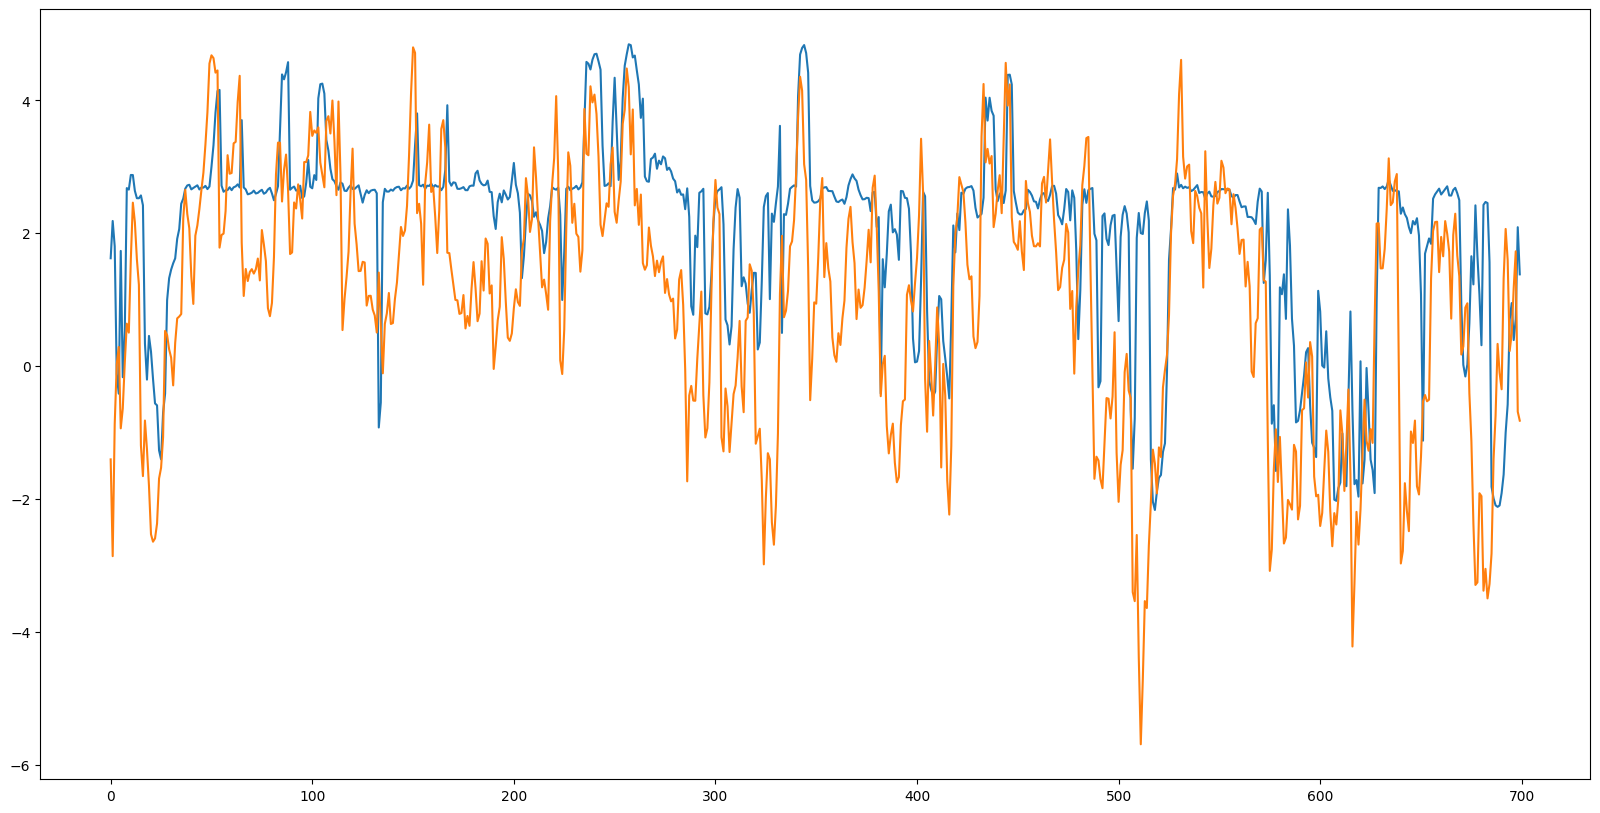

In [77]:
import matplotlib.pyplot as plt
#make plot bigger
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot((out*std)[start:end, 0], label="prediction")
plt.plot((y*std)[start:end, 0], label="ground truth")